## The Context

Australia has adopted an isolationist policy in response to the global coronavirus pandemic. Upon arriving in Australia, passengers are isolated in designated hotels for at least 14 days. While this process is highly effective, leaks can and do occur. Fortunately, these are regularly brought under control with effective contact tracing.

I had previously written a post applying MCMC to infer & estimate the effectiveness of different quarantine programmes. I'm using the same method in this post, building on top of the data provided in [this](https://www.medrxiv.org/content/10.1101/2021.02.17.21251946v2.full.pdf) paper.



## The Model

We can build a simple but effective model by treating the number of leaks as a *binomial* variable.

We can then infer the probability each processed person results in a leak based on the number of people processed and the number of leaks observed.

We need to provide a prior estimate for the probability of processing any one person resulting in a leak. We could guess that 1% of people returning have covid, and 1% of them will result in a leak, for a *probability of leak* of 0.0001. This seems like a reasonable assumption, and to encode it; I will use a beta distribution. 

What is the impact of using a more informed prior than when I last looked at this problem?

Well, in the case where we have less data, for example, in the case of ACT & Tasmania, we will end up with a smaller posterior estimate because we have used a more informed prior.

There will be little change in the case of other states/territories and countries, like NZ & NSW. The data will drown out our choice of prior.


In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams["figure.figsize"] = (20,20)
from warnings import filterwarnings
filterwarnings('ignore')

Let's create a pandas dataframe containing the data from the paper.

In [2]:
states = ['NZ','ACT','QLD','NSW','NT','SA','TAS','VIC','WA']
number_of_people_processed = [127_730,765,40_896,128_646,9_180, 13_023, 405, 33_300, 29_383, ]
number_of_leaks_observed = [10, 0, 3, 3, 0, 1, 0, 4, 1]
cases_identified_in_quarantine = [758, 25, 583, 1_581, 88, 230, 21, 462, 450]
data = {'State':states,'number_of_people_processed':number_of_people_processed, 'number_of_leaks_observed':number_of_leaks_observed, 'cases_identified_in_quarantine':cases_identified_in_quarantine}
data_df =  pd.DataFrame.from_dict(data)

display(data_df)

,State,number_of_people_processed,number_of_leaks_observed,cases_identified_in_quarantine
0,NZ,127730,10,758
1,ACT,765,0,25
2,QLD,40896,3,583
3,NSW,128646,3,1581
4,NT,9180,0,88
5,SA,13023,1,230
6,TAS,405,0,21
7,VIC,33300,4,462
8,WA,29383,1,450


In [3]:
num_chains = 2
num_samples = 1_000
with pm.Model() as leak_model: 
    #Set up our model
    prob_of_leak = pm.Beta('prob_of_leak',alpha=1,beta=10_000, shape=9)  
    number_of_leaks = pm.Binomial('number_of_leaks', n = data_df.number_of_people_processed, p = prob_of_leak, observed = data_df.number_of_leaks_observed)
    trace = pm.sample(draws = num_samples,chains=num_chains, tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [prob_of_leak]


Sampling 2 chains for 5_000 tune and 1_000 draw iterations (10_000 + 2_000 draws total) took 10 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [4]:
state_col = []
prob_of_leak_col = []
for i in range(0,9):
    state = states[i]
    prob_of_leak = trace.prob_of_leak[:,i]
    state_col += num_chains*num_samples*[state]
    prob_of_leak_col += list(prob_of_leak)

data = {'State':state_col,'prob_of_leak':prob_of_leak_col}
df =  pd.DataFrame.from_dict(data)

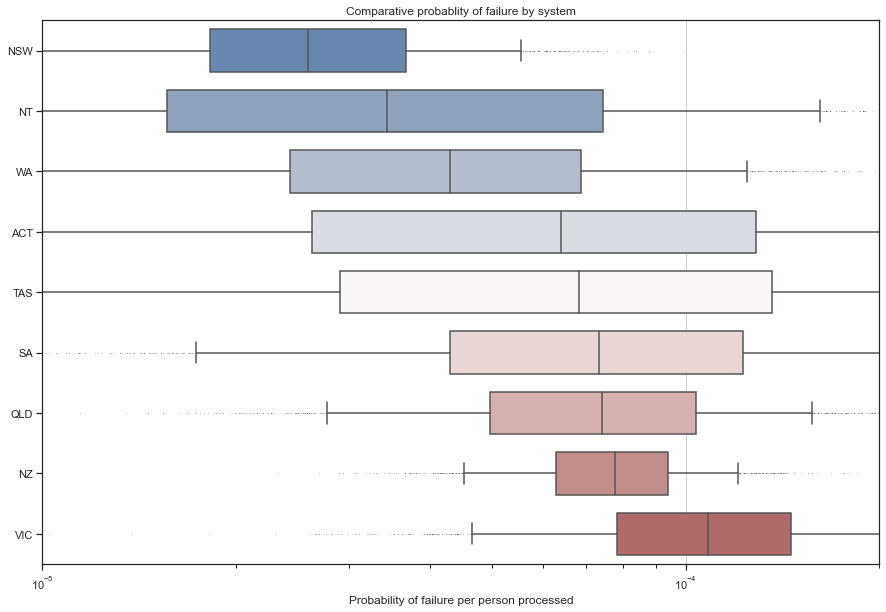

In [60]:
new_order = df.groupby(by=["State"])["prob_of_leak"].median().sort_values().index

#Visualise the data.
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(15, 10))
ax.set_xscale("log")

sns.boxplot(x="prob_of_leak", y="State", data=df, order = new_order, whis=[5, 95], width=0.7,
            palette="vlag", flierprops = dict(markerfacecolor = '0.0', markersize = 0.1))


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="Probability of failure per person processed")
ax.set_xlim(1*10**-5, 2* 10**-4)
ax.set(title="Comparative probablity of failure by system");